In [1]:
import wooldridge as woo
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import acorr_breusch_godfrey as bgtest
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import seaborn as sns
import gretltests
import matplotlib.pyplot as plt
import numpy as np
import augmentdata
from OLSAR1 import *

plt.rcParams['figure.figsize'] = [15, 6]


from statsmodels.tools.tools import add_constant
from statsmodels.tsa.arima.model import ARIMA

# Session 17 Slides

<Axes: >

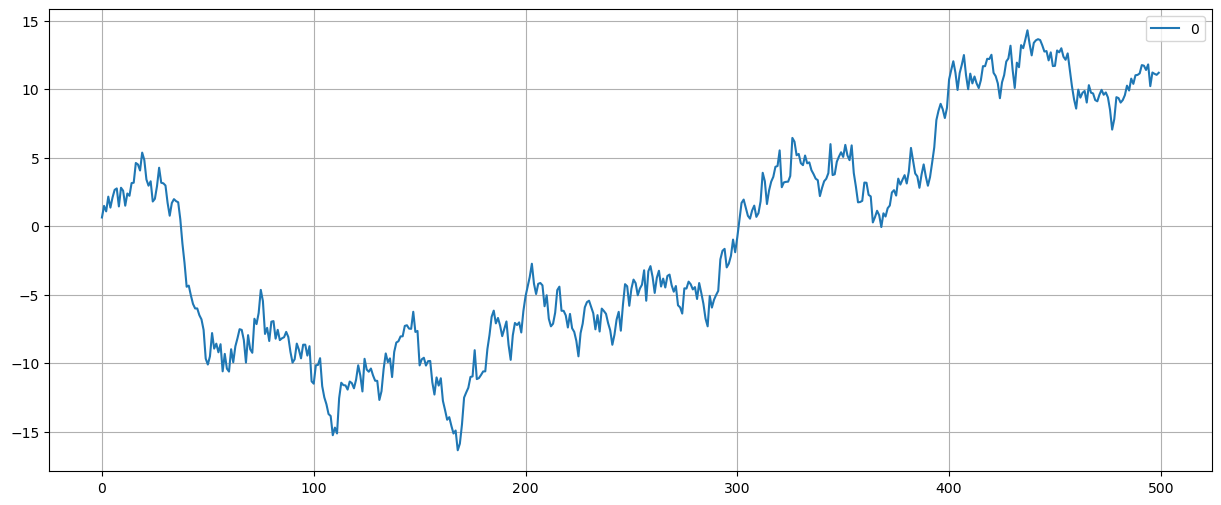

In [2]:
#To generate a AR1 series, you can change the following parameters
alpha1=1
alpha0=0
gama=.0


T=500    #The sample size
t=np.arange(T)
u=np.random.normal(0,1,T)
y=[]
for i in range(T):
    if i==0:
       if alpha1<1: 
           e=alpha0/(1-alpha1)+u[i]
       else:
           e=alpha0+u[i]
    else:
       e=alpha0+alpha1*e+gama*t[i]+u[i]
    y=y+[e]
pd.DataFrame(y).plot(grid=True)

In [3]:
nyse=woo.data('nyse')
woo.data('nyse',description=True)
nyse['lprice']=np.log(nyse['price'])

name of dataset: nyse
no of variables: 8
no of observations: 691

+----------+------------------------+
| variable | label                  |
+----------+------------------------+
| price    | NYSE stock price index |
| return   | 100*(p - p(-1))/p(-1)) |
| return_1 | lagged return          |
| t        |                        |
| price_1  |                        |
| price_2  |                        |
| cprice   | price - price_1        |
| cprice_1 | lagged cprice          |
+----------+------------------------+

These are Wednesday closing prices of value-weighted NYSE average,
available in many publications. I do not recall the particular source
I used when I collected these data at MIT. Probably the easiest way to
get similar data is to go to the NYSE web site, www.nyse.com.


<Axes: >

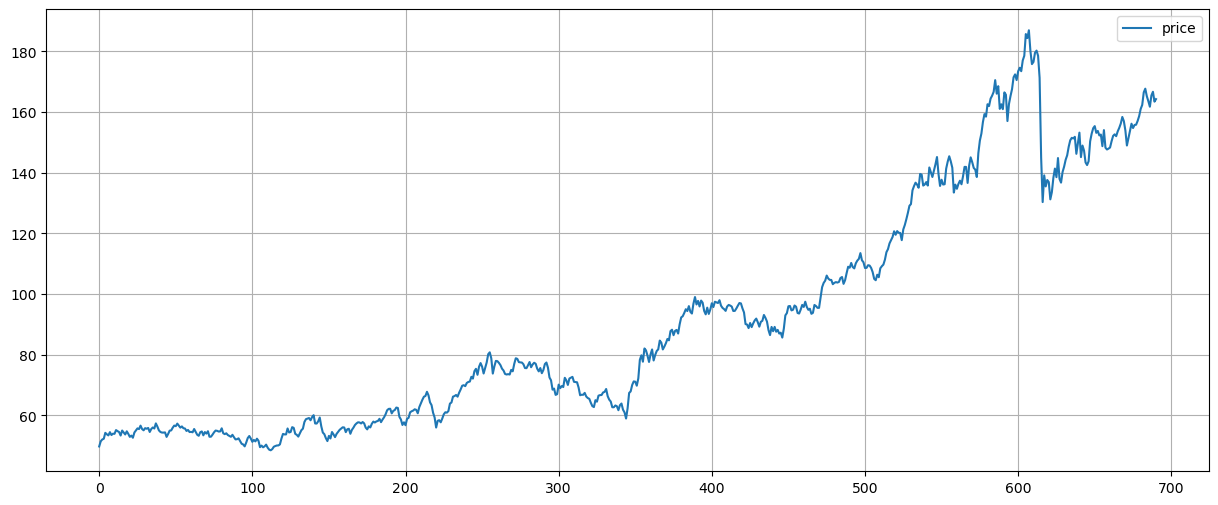

In [4]:
nyse.plot(y='price',grid=True)

<Axes: >

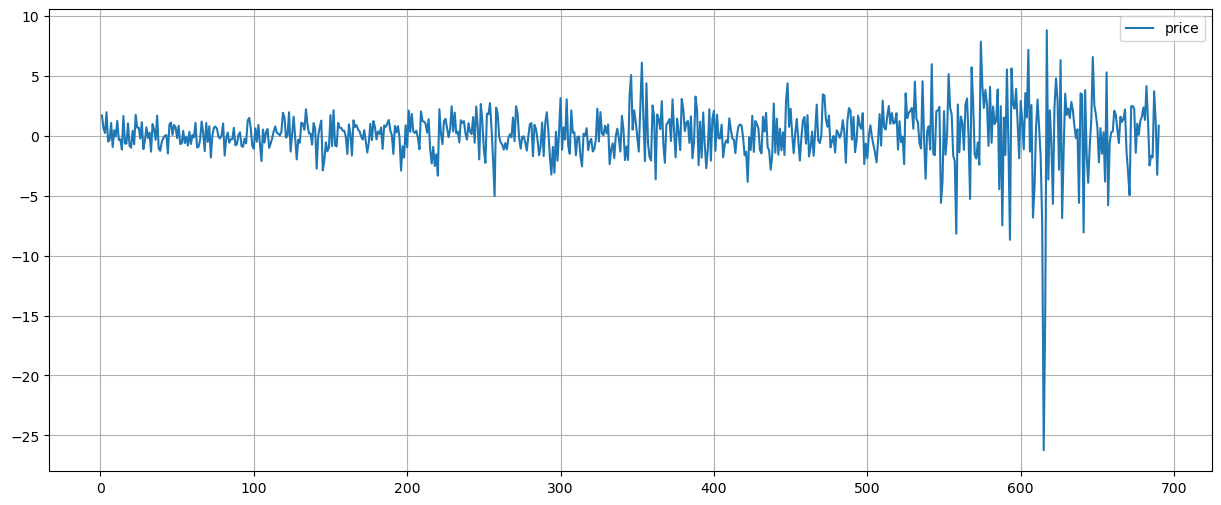

In [5]:
nyse.diff().plot(y='price',grid=True)

In [6]:
from statsmodels.tsa.arima.model import ARIMA

In [13]:
#Produces a slightly different result than gretl
#Note that the enforce invertibility statement plays a rold for model 2
#mod1 = ARIMA(nyse['lprice'], order=(1, 1, 1),trend='c',enforce_invertibility=True)
mod1 = ARIMA(nyse['lprice'], order=(1, 1, 1),enforce_invertibility=False)
res1 = mod1.fit()
#res2 = mod2.fit()wapltwa
print(res1.summary())
#print(res2.summary())

                               SARIMAX Results                                
Dep. Variable:                 lprice   No. Observations:                  691
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1678.799
Date:                Mon, 08 Apr 2024   AIC                          -3351.599
Time:                        12:37:02   BIC                          -3337.989
Sample:                             0   HQIC                         -3346.334
                                - 691                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7193      0.134     -5.366      0.000      -0.982      -0.457
ma.L1          0.7901      0.127      6.235      0.000       0.542       1.038
sigma2         0.0005   1.42e-05     31.848      0.0

In [14]:
wageprc=woo.data('wageprc')
woo.data('wageprc',description=True)

name of dataset: wageprc
no of variables: 20
no of observations: 286

+----------+----------------------------+
| variable | label                      |
+----------+----------------------------+
| price    | consumer price index       |
| wage     | nominal hourly wage        |
| t        | time trend = 1, 2 , 3, ... |
| lprice   | log(price)                 |
| lwage    | log(wage)                  |
| gprice   | lprice - lprice[_n-1]      |
| gwage    | lwage - lwage[_n-1]        |
| gwage_1  | gwage[_n-1]                |
| gwage_2  | gwage[_n-2]                |
| gwage_3  |                            |
| gwage_4  |                            |
| gwage_5  |                            |
| gwage_6  |                            |
| gwage_7  |                            |
| gwage_8  |                            |
| gwage_9  |                            |
| gwage_10 |                            |
| gwage_11 |                            |
| gwage_12 |                            |
| gpri

<Axes: >

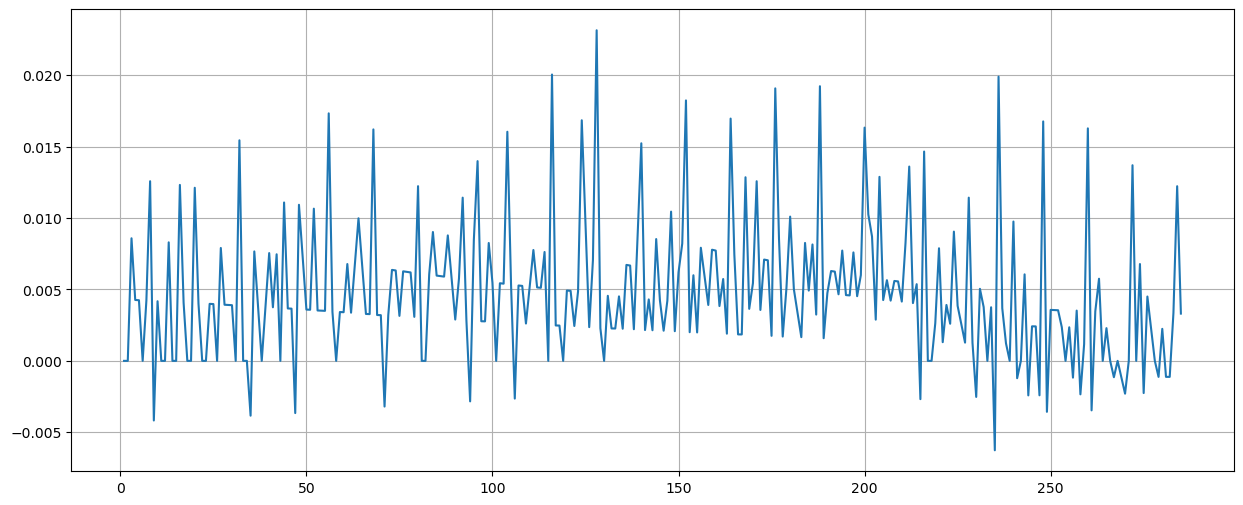

In [15]:
wageprc['gwage'].plot(grid=True)

In [16]:
month=[]
T=len(wageprc)
for j in range(round(T/12)):
    for i in range(1,13):
        month=month+[i]
month=month[0:T]
wageprc['month']=month
wageprc_=pd.get_dummies(wageprc, prefix='m', columns=['month'])
wageprc_.columns

Index(['price', 'wage', 't', 'lprice', 'lwage', 'gprice', 'gwage', 'gwage_1',
       'gwage_2', 'gwage_3', 'gwage_4', 'gwage_5', 'gwage_6', 'gwage_7',
       'gwage_8', 'gwage_9', 'gwage_10', 'gwage_11', 'gwage_12', 'gprice_1',
       'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10',
       'm_11', 'm_12'],
      dtype='object')

In [17]:
form='gwage~gwage_1'
for i in range(11):
    form=form+'+m_'+str(i+1)
mod0=ols(form,data=wageprc_).fit()
print(mod0.summary())


                            OLS Regression Results                            
Dep. Variable:                  gwage   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     27.49
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           3.05e-40
Time:                        12:39:02   Log-Likelihood:                 1221.6
No. Observations:                 284   AIC:                            -2417.
Df Residuals:                     271   BIC:                            -2370.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0017      0.001      2.387   

In [18]:
form='gwage~gwage_1'
for i in range(12):
    form=form+'+gwage_'+str(i+1)
mod1=ols(form,data=wageprc_).fit()
print(mod1.summary())

                            OLS Regression Results                            
Dep. Variable:                  gwage   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     24.71
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           1.68e-36
Time:                        12:40:52   Log-Likelihood:                 1169.3
No. Observations:                 273   AIC:                            -2313.
Df Residuals:                     260   BIC:                            -2266.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0010      0.001      1.438      0.1

In [19]:
greene=pd.read_csv('greene11_3.csv')
greene.index=greene['obs']
greene['time']=np.arange(1,len(greene)+1)

In [20]:
mod2=ols('C~Y',data=greene).fit()
print(mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                      C   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.359e+04
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           6.61e-50
Time:                        12:45:10   Log-Likelihood:                -155.71
No. Observations:                  36   AIC:                             315.4
Df Residuals:                      34   BIC:                             318.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.3737      9.629      1.181      0.2

In [21]:
mod2=ols('C~Y+time',data=greene).fit()
print(mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                      C   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.147e+04
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           1.25e-47
Time:                        12:45:15   Log-Likelihood:                -155.68
No. Observations:                  36   AIC:                             317.4
Df Residuals:                      33   BIC:                             322.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.5781     32.511      0.571      0.5

In [22]:
mod3=OLSAR1(mod2)
print(mod3.summary())

Rho =  0.6981653399026667
Rho =  0.7404065178919994
Rho =  0.7614128723129368
Rho =  0.7731967226461888
Rho =  0.780323852313386
Rho =  0.7848419963436248
Rho =  0.787793712948926
Rho =  0.7897604601630529
Rho =  0.7910882409143016
Rho =  0.791992625075002
Rho =  0.7926123505117383
Rho =  0.7930387727869266
Rho =  0.793333021409459
Rho =  0.7935364632205182
Rho =  0.7936773124163546
Rho =  0.7937749182589557
Rho =  0.7938426012376376
Rho =  0.793889555906792
Rho =  0.7939221406156308
Rho =  0.7939447580374469
Rho =  0.7939604594140068
Rho =  0.793971360700336
Rho =  0.793978929888031
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     894.7
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           8.24e-29
Time:         

In [23]:
#The following command are contained in gretl tests and make it easy to to DL or ARDL 
formula,dat=gretltests.ARDL(greene,y='C',x=['Y'],maxlag=[1,1])
formula=formula+'+time' #add on any non-lagged explanatory variables
mod4=ols(formula,data=dat).fit()
print(mod4.summary())
formula

                            OLS Regression Results                            
Dep. Variable:                      C   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     8137.
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           4.64e-45
Time:                        12:45:26   Log-Likelihood:                -143.06
No. Observations:                  35   AIC:                             296.1
Df Residuals:                      30   BIC:                             303.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.2237     27.986      0.866      0.3

'C~+C_1+Y+Y_1+time'

In [24]:
#The long run coefficient is:
b=mod4.params
(b['Y']+b['Y_1'])/(1-b['C_1'])

0.7642759522085092

# Session 17 Interactive

In [25]:
hseinv=woo.data('hseinv')
woo.data('hseinv',description=True)
hseinv.index=hseinv['year']

name of dataset: hseinv
no of variables: 14
no of observations: 42

+----------+-------------------------------+
| variable | label                         |
+----------+-------------------------------+
| year     | 1947-1988                     |
| inv      | real housing inv, millions $  |
| pop      | population, 1000s             |
| price    | housing price index; 1982 = 1 |
| linv     | log(inv)                      |
| lpop     | log(pop)                      |
| lprice   | log(price)                    |
| t        | time trend: t=1,...,42        |
| invpc    | per capita inv: inv/pop       |
| linvpc   | log(invpc)                    |
| lprice_1 | lprice[_n-1]                  |
| linvpc_1 | linvpc[_n-1]                  |
| gprice   | lprice - lprice_1             |
| ginvpc   | linvpc - linvpc_1             |
+----------+-------------------------------+

D. McFadden (1994), “Demographics, the Housing Market, and the Welfare
of the Elderly,” in D.A. Wise (ed.), Studies in th

In [26]:
mod5=ols('linvpc~lprice+t',data=hseinv).fit()
mod6=OLSAR1(mod5)
print(mod6.summary())

Rho =  0.49648279883416147
Rho =  0.5025808584772283
Rho =  0.50377076336209
Rho =  0.5040054957624652
Rho =  0.5040518995063025
Rho =  0.5040610767888395
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     2.606
Date:                Mon, 08 Apr 2024   Prob (F-statistic):             0.0870
Time:                        12:46:41   Log-Likelihood:                 28.283
No. Observations:                  41   AIC:                            -50.57
Df Residuals:                      38   BIC:                            -45.43
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t| 

In [27]:
#The following command are contained in gretl tests and make it easy to to DL or ARDL 
formula,dat=gretltests.ARDL(hseinv,y='linvpc',x=['lprice'],maxlag=[0,1])
formula=formula+'+t' #add on any non-lagged explanatory variables
mod7=ols(formula,data=dat).fit()
print(mod7.summary())

                            OLS Regression Results                            
Dep. Variable:                 linvpc   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     15.96
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           8.09e-07
Time:                        12:46:41   Log-Likelihood:                 32.492
No. Observations:                  41   AIC:                            -56.98
Df Residuals:                      37   BIC:                            -50.13
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0865      0.115     -9.418      0.0

In [28]:
#The following command are contained in gretl tests and make it easy to to DL or ARDL 
formula,dat=gretltests.ARDL(hseinv,y='linvpc',x=['lprice'],maxlag=[1,1])
formula=formula+'+t' #add on any non-lagged explanatory variables
mod8=ols(formula,data=dat).fit()
print(mod8.summary())

                            OLS Regression Results                            
Dep. Variable:                 linvpc   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     15.95
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           1.34e-07
Time:                        12:46:42   Log-Likelihood:                 36.371
No. Observations:                  41   AIC:                            -62.74
Df Residuals:                      36   BIC:                            -54.17
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7948      0.151     -5.279      0.0

In [29]:
#You can run a AR1 on the lagged model but you should really do more lags
mod9=OLSAR1(mod8)
print(mod9.summary())

Rho =  0.4090620826089099
Rho =  0.43241187109434154
Rho =  0.438989202631207
Rho =  0.4408660993992853
Rho =  0.4414036868333261
Rho =  0.4415578295097206
Rho =  0.44160204049308405
Rho =  0.4416147221428366
Rho =  0.44161835988841497
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     9.863
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           1.88e-05
Time:                        12:48:04   Log-Likelihood:                 38.989
No. Observations:                  40   AIC:                            -67.98
Df Residuals:                      35   BIC:                            -59.53
Df Model:                           4                                         
Covariance Type:            nonrobust                

In [ ]:
#The following command are contained in gretl tests and make it easy to to DL or ARDL 
formula,dat=gretltests.ARDL(hseinv,y='linvpc',x=['lprice'],maxlag=[2,2])
formula=formula+'+t' #add on any non-lagged explanatory variables
mod10=ols(formula,data=dat).fit()
print(mod10.summary())